In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import json
import re
from sklearn.metrics import accuracy_score
import seaborn as sns

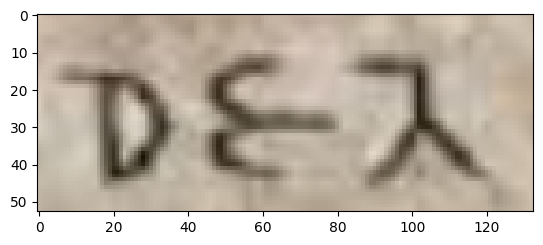

4


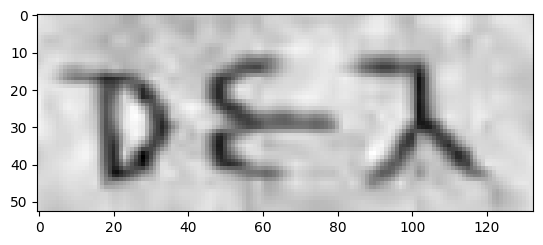

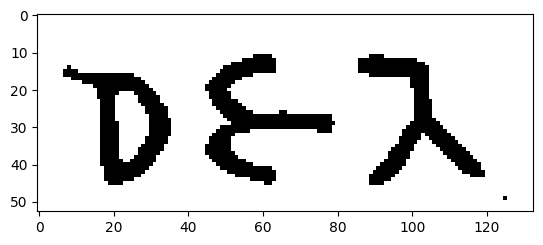

True

In [15]:
#Preprocessing Script Inscription Image
# Skew Correction Function
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = cv2.rotate(arr, angle)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated

image = cv2.imread('test_img/script_11.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Skew correction
angle, rotated = correct_skew(image)
print(angle)
cv2.imwrite('rotated.jpg', rotated)


# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

# Median blur
filter1 = cv2.medianBlur(gray, 5)

# Gaussian blur
filter2 = cv2.GaussianBlur(filter1, (5, 5), 0)

# Denoising
dst = cv2.fastNlMeansDenoising(filter2, None, 17, 9, 17)
# plt.imshow(dst, cmap='gray')
plt.show()

# Binarization
th1 = cv2.adaptiveThreshold(dst, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(th1, cmap='gray')
plt.show()

# Save preprocessed image
cv2.imwrite('PreProcessed.jpg', th1)


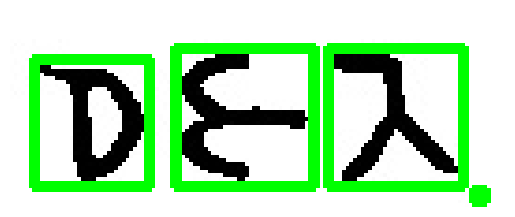

True

In [16]:
#Character Segmentation by contour detection
image = cv2.imread("PreProcessed.jpg")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Apply dilation to enhance the contours
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=1)

# Find contours in the dilated image
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes around each contour
letter_image = image.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(letter_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(letter_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

cv2.imwrite('box.jpg', letter_image)


In [17]:
#Saving segmented image in a Temp folder
input_image_path = "box.jpg"  
output_folder = "output_images"  
extract_images(input_image_path, output_folder)

def extract_images(input_image_path, output_folder):

    # Load the image
    image = cv2.imread(input_image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    # Sort contours based on x-coordinate
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])

    # Iterate through each contour and extract images inside the boundary boxes
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # Check if either height or width is less than 20 pixels
        if h < 20 or w < 20:
            continue
        
        cropped_image = image[y:y+h, x:x+w]
        
        # Save the cropped image with a unique name
        output_path = os.path.join(output_folder, f"{i}.png")
        cv2.imwrite(output_path, cropped_image)
        
        # Print the shape of the cropped image
        print(f"Image {i}.png shape: {cropped_image.shape}")


NameError: name 'extract_images' is not defined

In [ ]:
#Model Building

# Define data generators for training and validation sets
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory('C:/Users/ayaan/OneDrive/Desktop/Brahmi/train/',
                                          target_size=(200, 200),
                                          batch_size=32,
                                          class_mode='categorical')

validation_dataset = validation.flow_from_directory('C:/Users/ayaan/OneDrive/Desktop/Brahmi/validation/',
                                                    target_size=(200, 200),
                                                    batch_size=32,
                                                    class_mode='categorical')

print(train_dataset.class_indices)
# train_dataset.classes

Found 4250 images belonging to 170 classes.
Found 4250 images belonging to 170 classes.
{'அ': 0, 'ஆ': 1, 'இ': 2, 'ஏ': 3, 'க': 4, 'க2': 5, 'க3': 6, 'கா': 7, 'கா3': 8, 'கி': 9, 'கி3': 10, 'கீ': 11, 'கீ3': 12, 'கு': 13, 'கு3': 14, 'கூ': 15, 'கூ3': 16, 'கே': 17, 'கே3': 18, 'கோ': 19, 'கோ3': 20, 'க்': 21, 'ங': 22, 'ஙா': 23, 'ஙி2': 24, 'ஙீ2': 25, 'ஙு': 26, 'ஙூ': 27, 'ஙே': 28, 'ங்': 29, 'ச': 30, 'ச2': 31, 'சா': 32, 'சா2': 33, 'சி': 34, 'சி2': 35, 'சீ': 36, 'சீ2': 37, 'சு3': 38, 'சே': 39, 'சே2': 40, 'ச்': 41, 'ச்2': 42, 'ஜ': 43, 'ஜ2': 44, 'ஜா': 45, 'ஜி': 46, 'ஜீ': 47, 'ஜே': 48, 'ஜோ': 49, 'ஜ்': 50, 'ஜ்2': 51, 'ஞ': 52, 'ஞா': 53, 'ஞ்': 54, 'ட': 55, 'ட2': 56, 'டா': 57, 'டா2': 58, 'டி': 59, 'டி2': 60, 'டீ': 61, 'டீ2': 62, 'டே': 63, 'ட்': 64, 'ட்2': 65, 'ண': 66, 'ணா': 67, 'ணி': 68, 'ணீ': 69, 'ணு': 70, 'ணூ': 71, 'ணே': 72, 'ணோ': 73, 'ண்': 74, 'த': 75, 'த2': 76, 'த3': 77, 'த4': 78, 'தா': 79, 'தா2': 80, 'தா3': 81, 'தா4': 82, 'தி': 83, 'தி2': 84, 'தி3': 85, 'தி4': 86, 'தீ': 87, 'தீ2': 88, 'தீ3': 89, 'தீ4'

In [ ]:
# Defining the CNN model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(170, activation='softmax')  
])


# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001), 
              metrics=['accuracy'])



In [ ]:
# Train the model
model_fit = model.fit(train_dataset,
                      steps_per_epoch=len(train_dataset),
                      epochs=10,
                      validation_data=validation_dataset,
                      validation_steps=len(validation_dataset))

In [ ]:
# Save the model to a file
model.save('my_model.h5')

In [ ]:
# Save the class indices to a JSON file
class_indices = train_dataset.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

In [ ]:
accuracy = max(model_fit.history['accuracy'])
print("Accuracy:", accuracy)

Accuracy: 0.9781176447868347


In [ ]:
#Character Recognition
folder_path = 'output_images'
predicted_labels = []

# Iterate over each image in the folder
for img_name in os.listdir(folder_path):
    if img_name.startswith('.'): 
        continue
    img_path = os.path.join(folder_path, img_name)
    
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(200, 200))
    plt.imshow(img)
    plt.show()
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    
    # Get the predicted class label
    prediction = model.predict(X)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = [k for k, v in train_dataset.class_indices.items() if v == predicted_class_index][0]
    predicted_labels.append(predicted_class_name)

    # Output predicted class name for each image
    print("Image:", img_name)
    print("Predicted class name:", predicted_class_name)

print("\n")

# Concatenate the predicted characters into a word
Word_formation = ''.join(predicted_labels)
reconstructed_text = re.sub(r'\d+', '', Word_formation)
print("Reconstructed Text:", reconstructed_text)
